In [1]:
cd ..

/home/mars/Documents/phd_code/src_aiai


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from src.operators.measurement import NUFFT_op, NUFFT_op_TF, calculate_kaiser_bessel_coef
from src.sampling.uv_sampling import spider_sampling
import tqdm
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [3]:
 Nd, Kd, Jd = (256,256), (512,512), (6,6)

In [4]:
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)

    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)

In [5]:
class Gradient(tf.keras.layers.Layer):
    def __init__(self, m_op, shape_x, shape_y, depth, learned=False):
        self.m_op = m_op
        self.learned = learned
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    

    def __call__(self, x, y):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.forward(x) 
        size = y.shape[1]
        res = m -  y
        if not self.learned:
            grad = self.m_op.adjoint( res )
        else:
            grad = self.m_op.learned_adj_op( res )
        return tf.cast(grad, tf.float32)

In [6]:
uv = spider_sampling()
# op = TF_nufft()
op = NUFFT_op_TF()
op.plan(uv, Nd, Kd, Jd, 2)

100%|██████████| 4440/4440 [00:00<00:00, 5327.91it/s]


In [7]:
x_tf = tf.convert_to_tensor(np.ones((2,256,256,1)))
y_tf = tf.cast(tf.convert_to_tensor(np.ones((2,4440,1)) +0j), tf.complex64)

In [8]:
g = Gradient(op, [None, 256,256], [None, 4440], 0, True)

In [9]:
a = g(x_tf[:, :,:, 0], y_tf[:, :, 0]).numpy().real

In [10]:
a.shape

(2, 256, 256)

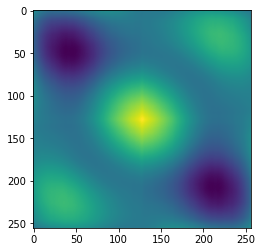

In [11]:
plt.imshow(a[0])

In [12]:
gradient_layers = []
depth = 4
for i in range(depth):
#     m_op = TF_nufft()
    m_op = NUFFT_op_TF()
    
    nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
    print(nd, kd)
    sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
    m_op.plan(uv[sel], nd, kd, Jd, 2)
    gradient_layers.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i, True) )

 11%|█████▎                                           | 477/4440 [00:00<00:00, 4764.57it/s]

(256, 256) (512, 512)


 13%|██████▏                                          | 556/4414 [00:00<00:00, 5554.01it/s]

(128, 128) (256, 256)


 19%|█████████▎                                       | 560/2960 [00:00<00:00, 5591.14it/s]

(64, 64) (128, 128)


 38%|██████████████████▍                              | 558/1480 [00:00<00:00, 5571.72it/s]

(32, 32) (64, 64)


100%|████████████████████████████████████████████████| 1480/1480 [00:00<00:00, 5513.30it/s]


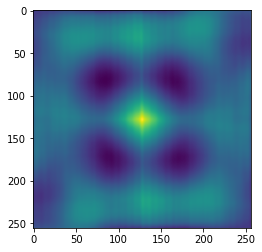

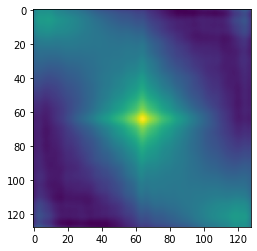

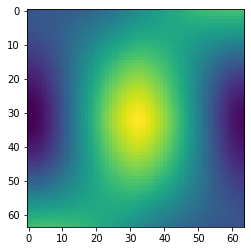

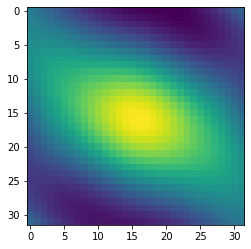

In [13]:
for i in range(depth):
    x_tf = tf.convert_to_tensor(np.ones((2, Nd[0]//2**i, Nd[1]//2**i)))
    y_tf = tf.cast(tf.convert_to_tensor(0j + np.ones((2,np.sum(np.linalg.norm(uv, axis=1) < np.pi / 2**i)))), tf.complex64)

    plt.imshow(gradient_layers[i](x_tf, y_tf).numpy().real[0])
    plt.show()

# simple test

In [7]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [15]:
class Unet(tf.keras.Model):
    def __init__(self, input_shape, uv, depth=2, start_filters=16, conv_layers=1, kernel_size=3, conv_activation='relu', output_activation='linear', grad=False):
        grad_on_upsample = True
        learned_grad = True

        batch_size = 2
        self.is_adapted=False
        inputs = tf.keras.Input(input_shape)
        
        x = inputs
        skips = []
        
        Nd = (input_shape[0], input_shape[1])
        Kd = (Nd[0]*2, Nd[1]*2)
        Jd = (6,6)

        if grad:
            inputs2 = tf.keras.Input([len(uv),1], dtype=tf.complex64) # individual measurements
            # construct gradient operators
            gradient_ops = []
            subsampled_inputs = []
    

            for i in range(depth):
#                 m_op = TF_nufft() # numpy function tf operator
                m_op = NUFFT_op_TF() # TF native operator
                nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
                sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
                m_op.plan(uv[sel], nd, kd, Jd, batch_size)
                gradient_ops.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i, learned_grad) )
                subsampled_inputs.append(tf.boolean_mask(inputs2, sel, axis=1))


        # convolution downward
        for i in range(depth):
            
            shape = (None, Nd[0]//2**i, Nd[1]//2**i)
            
            if grad:
                # gradients
                with tf.name_scope("Grad_" +str(i)):
                    gradi = gradient_ops[i](x[:,:,:,0], subsampled_inputs[i][:,:,0])
                    gradi.set_shape(shape)
                    x = tf.keras.layers.Concatenate()([x, gradi[:,:,:, None]])
            
            
            for j in range(conv_layers):
                x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**(i), 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same',
                    name="conv2d_down_depth_" + str(i) + "_" + str(j)
                )(x)
                x = tf.keras.layers.BatchNormalization(
                    name="BatchNorm_down_depth_" + str(i) + "_" + str(j)
                )(x)
            skips.append(x)
            x = tf.keras.layers.MaxPool2D(padding='same')(x)


        # smallest layer
        for i in range(conv_layers):
            x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**depth, 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)



        # convolutions upward
        for i in range(depth):
            shape = (None, Nd[0]//2**(depth-i-1), Nd[1]//2**(depth-i-1))

            x = tf.keras.layers.UpSampling2D()(x)

            if grad and grad_on_upsample:
                # gradients
                with tf.name_scope("Grad_up_" +str(i)):
                    gradi = gradient_ops[-(i+1)](x[:,:,:,0], subsampled_inputs[-(i+1)][:,:,0])
                    gradi.set_shape(shape)
                    x = tf.keras.layers.Concatenate()([x, gradi[:,:,:, None]])
            
            x = tf.keras.layers.Concatenate()([x,skips[-(i+1)]])


            for j in range(conv_layers):
                x = tf.keras.layers.Conv2D(
                    filters=start_filters*2**(depth-(i+1)), 
                    kernel_size=kernel_size, 
                    activation=conv_activation, 
                    padding='same',
                    name="conv2d_up_depth_" + str(i) + "_" + str(j)
                )(x)
                x = tf.keras.layers.BatchNormalization(
                    name="BatchNorm_up_depth_" + str(i) + "_" + str(j)
                )(x)
                        
        # output formatting
        outputs = tf.keras.layers.Conv2D(
                    filters=1, 
                    kernel_size=1, 
                    padding='same',
                    activation=output_activation,
                    name="conv2d_output"
                    )(x)

        if grad:
            super().__init__(inputs=[inputs, inputs2], outputs=outputs)
        else:
            super().__init__(inputs=[inputs], outputs=outputs)

        self.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [16]:
model = Unet(input_shape=(256,256,1), uv=uv, depth=2, start_filters=4, conv_layers=1, kernel_size=3, conv_activation='relu', output_activation='linear', grad=True)


100%|██████████| 4414/4414 [00:00<00:00, 5236.55it/s]


In [17]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Grad_0/strided_slic [(None, 256, 256)]   0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Grad_0/Cast (Tensor [(None, 256, 256)]   0           tf_op_layer_Grad_0/strided_slice[
__________________________________________________________________________________________________
tf_op_layer_Grad_0/truediv (Ten [(None, 256, 256)]   0           tf_op_layer_Grad_0/Cast[0][0]    
_______________________________________________________________________________________________

In [19]:
x, y = np.ones((20,256,256,1)), np.ones((20,4440,1)) +0j

In [19]:
model.fit((x, y), x, batch_size=2, epochs=3)

Train on 2 samples
Epoch 1/3
2/2 [==============================] - 6s 3s/sample - loss: 2.1427
Epoch 2/3
2/2 [==============================] - 2s 1s/sample - loss: 2.0101
Epoch 3/3
2/2 [==============================] - 2s 987ms/sample - loss: 1.9390


In [8]:
Nd, Kd, Jd = (256,256), (512,512), (6,6)
batch_size = 20
op = NUFFT_op_TF()
op.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 4440/4440 [00:00<00:00, 5296.13it/s]


In [16]:
class bp(tf.keras.Model):
    def __init__(self, input_shape, uv, learned=False, batch_size=20):
        
        Nd, Kd, Jd = (256,256), (512,512), (6,6)
        self.batch_size = batch_size
#         op = NUFFT_op_TF()
        op = op2()
        
        op.plan(uv, Nd, Kd, Jd, batch_size)

        
        # input shape should always be measurements: [None, M, 1]
        inputs = tf.keras.Input(input_shape, dtype=tf.complex64)
        
        if not learned:
            x_init = tf.math.real(op.adjoint(inputs[:,:,0]))
        else:
            x_init = tf.math.real(op.learned_adj_op(inputs[:,:,0]))
        
        super().__init__(inputs=[inputs], outputs=x_init)

        self.compile(optimizer='adam', loss= tf.keras.losses.MSE)
    
        if not learned:
            self.fit = lambda *args: None
            
    def fit(self, x, y, **kwargs):
        x = x[:len(x)//self.batch_size*self.batch_size] # currently only possible to predict an exact multiple of the batch size
        y = y[:len(y)//self.batch_size*self.batch_size] # currently only possible to predict an exact multiple of the batch size
        
        return super().fit(x, y, batch_size=self.batch_size, **kwargs)
            
    def predict(self, x, **kwargs):
        x = x[:len(x)//self.batch_size*self.batch_size] # currently only possible to predict an exact multiple of the batch size
        return super().predict(x, batch_size=self.batch_size, **kwargs)
#     def fit(self, *args):
#         return
    

In [17]:
class op2(NUFFT_op_TF):
    def learned_adj_op(self, k):
            """adjoint operation with a convolutional layer between interpolation and FT"""
            # split real and imaginary parts because complex operations not defined for sparseTensors
            # k = k[:,:, None, None] # adding axes for sparse multiplication; shape 
            k = tf.expand_dims(k, axis=2)[:,:,:,None] # adding axes for sparse multiplication; shape [batch_size, M, 1, 1]
            k_real = tf.math.real(k)
            k_imag = tf.math.imag(k)
            # kk_real = self._k2kk(k_real)[:,:,:,None]
            # kk_imag = self._k2kk(k_imag)[:,:,:,None]

            kk_real = tf.expand_dims(self._k2kk(k_real), axis=3)
            kk_imag = tf.expand_dims(self._k2kk(k_imag), axis=3)

            conv = tf.keras.layers.Conv2D(1, (3,3), activation='relu', padding="same")

            # kk_real = tf.cast(conv(kk_real), tf.complex64)[:,:,:,0]
            # kk_imag = tf.cast(conv(kk_imag), tf.complex64)[:,:,:,0]

            kk_real = tf.squeeze(tf.cast(conv(kk_real), tf.complex64))
            kk_imag = tf.squeeze(tf.cast(conv(kk_imag), tf.complex64))

            kk = kk_real + 1j* kk_imag
            xx = self._kk2xx(kk)
            xx = self._unpad(xx)
            xx = xx / self.scaling
            return xx

In [18]:
x, y = np.ones((20,256,256,1)), np.ones((20,4440,1)) +0j
# x0 = op.adjoint(tf.convert_to_tensor(y[:,:,0]))

In [22]:
tf.keras.backend.clear_session()

In [20]:
b = bp((4440,1), uv, learned=True)

100%|██████████| 4440/4440 [00:00<00:00, 5368.49it/s]


In [ ]:
b.fit(y,c[:,:,:])

Train on 20 samples


In [ ]:
c = b.predict(y)

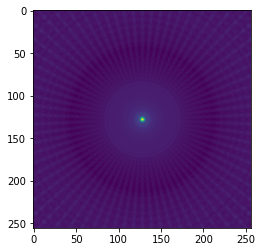

In [40]:
plt.imshow(c[0].real)

In [21]:
b.summary()

Model: "bp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4440, 1)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 4440)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 4440, 1)]    0           tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 4440, 1, 1)] 0           tf_op_layer_ExpandDims[0][0]     
_________________________________________________________________________________________________

In [ ]:
class test():
    def __init__():


#         inputs
#         (learned/weighted) adjoint transform
#         for depth
#             skip
#             grad, concat
#             conv
        
#         for depth
#             grad, concat
#             skip concat
#             conv
            
#         output

In [33]:
class CSV_logger_plus(tf.keras.callbacks.CSVLogger):
    def on_train_begin(self, logs=None):
        self.t0 = time.time() # start time
        super().on_train_begin(logs)
    
    def on_epoch_end(self, epoch, logs=None):
        logs['time'] = time.time() - self.t0
        super().on_epoch_end(epoch, logs)

In [8]:
from src.network import Unet
import time

In [9]:
tf.keras.backend.clear_session()

In [10]:
a = Unet(
    (256,256,1), 
    uv=uv, 
    depth=2, 
    start_filters=2, 
    conv_layers=1, 
    kernel_size=3, 
    conv_activation='relu', 
    output_activation='linear', 
    grad=False, 
    learned_adjoint=True, 
    learned_grad=False, 
    grad_on_upsample=False
)

100%|██████████| 4440/4440 [00:00<00:00, 5229.21it/s]


In [25]:
# a.summary()

In [11]:
x, y = np.ones((20,256,256)), np.ones((20,4440)) +0j

In [34]:
# cb = TimeOut(10, "")
cb = CSV_logger_plus('test.log')

In [35]:
a.fit(y, x, epochs=20, callbacks=[cb])

Train on 20 samples
Epoch 1/20
20/20 [==============================] - 4s 219ms/sample - loss: 1.4696
Epoch 2/20
20/20 [==============================] - 4s 220ms/sample - loss: 1.4581
Epoch 3/20
20/20 [==============================] - 4s 220ms/sample - loss: 1.4471
Epoch 4/20


KeyboardInterrupt: 

In [12]:
b = a.predict(y)

/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


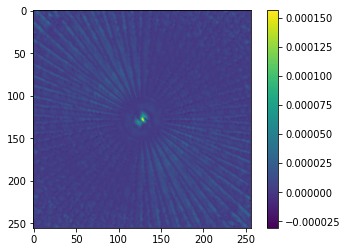

In [13]:
plt.imshow(b[0])
plt.colorbar()